# Treinamento do modelo

## Carregando imagens no Keras usando Image data preprocessing API

Para treinar um modelo com grande quantidade de imagens, é impossível carregar as imagens pela memória RAM. Isso se deve ao fato de que as imagens em formato de `np.arrays` ocupam muito espaço. Por exemplo, 8000 imagens coloridas jpeg com resolução 227x227 ocupam mais de 4GB de memória quando transformadas em `np.arrays`, usando o tipo float32.
Assim, faz-se necessário carregar as imagens do disco ao longo das épocas de treinamento do modelo. Para isso, utiliza-se a API de preprocessamento de imagens do Keras ([Keras Image data preprocessing API](https://keras.io/api/preprocessing/image/)). Essa API carrega cada batch de imagens do disco em formato jpeg, e pode ser utilizada para escalonar e redimensionar as imagens. A categorização das imagens também é feita pela API, com base na estrutura dos diretórios.

Ver [video](https://www.youtube.com/watch?v=uqomO_BZ44g&list=PLgBQhd3MrsBC1_84TIcP5edUlx8h3y16Q). API docs [aqui](https://keras.io/api/preprocessing/image/)

In [18]:
# this import statement garantees that tensorflow 2.0 will behave like 1.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1.keras.preprocessing import image

W1116 15:04:28.906891 140464286693184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/compat/v2_compat.py:68: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


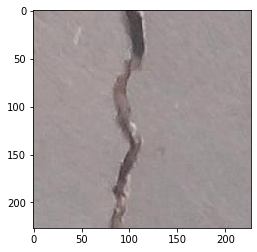

In [3]:
# Ver imagens no diretorio
DATASET_DIRECTORY = 'ozgenel_dataset_split'
plt.imshow(image.load_img(DATASET_DIRECTORY + "/test/Positive/00013.jpg"))

In [2]:
img_generator = ImageDataGenerator(rescale = 1/255)

In [3]:
train_dataset = img_generator.flow_from_directory(
    DATASET_DIRECTORY + '/train',
    target_size=(227, 227),
    batch_size = 1024,
    class_mode = "categorical")
val_dataset = img_generator.flow_from_directory(
    DATASET_DIRECTORY + '/val',
    target_size=(227, 227),
    batch_size = 1024,
    class_mode = "categorical")
test_dataset = img_generator.flow_from_directory(
    DATASET_DIRECTORY + '/test',
    target_size=(227, 227),
    batch_size = 1024,
    class_mode = "categorical")

Found 28001 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


In [4]:
def checkDatasets(train, val):
    batchX, batchy = train.next()
    print('Train Dataset info:\nBatch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
    batchX, batchy = val.next()
    print('Validation Dataset info:\nBatch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

checkDatasets(train_dataset, val_dataset)

Train Dataset info:
Batch shape=(32, 227, 227, 3), min=0.000, max=1.000
Validation Dataset info:
Batch shape=(32, 227, 227, 3), min=0.000, max=1.000


## Arquitetura do modelo

In [1]:
# this import statement garantees that tensorflow 2.0 will behave like 1.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow import keras
from tensorflow.keras import layers, activations
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = tf.keras.Sequential()
#C1
model.add(Conv2D(3, (20,20), strides=2, padding='same', input_shape=(227, 227,3)))
#P1
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(7,7), strides=2))
#C2
model.add(Conv2D(24, (15,15), strides=2, padding='same'))
model.add(BatchNormalization())
#P2
model.add(MaxPooling2D(pool_size=(4,4), strides=2))
#C3
model.add(Conv2D(48, (10,10), strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(layers.Activation(activations.relu))
#C4
model.add(Conv2D(96, (1,1),  strides=1, padding='same'))
model.add(Flatten())
model.add(Dense(96))
model.add(Dense(2, activation='softmax'))
model.summary()

W1116 18:26:52.141839 140515565217600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/compat/v2_compat.py:68: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
W1116 18:26:52.164727 140515565217600 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 114, 114, 3)       3603      
_________________________________________________________________
batch_normalization (BatchNo (None, 114, 114, 3)       12        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 24)        16224     
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 24)        96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 48)          1

In [6]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint   

with tf.device('/gpu:0'):
# train the model
    checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                                   save_best_only=False)
    hist = model.fit_generator(
        train_dataset,
        steps_per_epoch=28,
        validation_data=val_dataset,
        validation_steps=6,
        verbose=2,
        epochs=50
    )

Epoch 1/5


W1116 03:47:40.000182 139621639501632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Epoch 1/5
870/870 - 108s - loss: 0.1374 - acc: 0.9772 - val_loss: 0.1099 - val_acc: 0.9649
Epoch 2/5
Epoch 1/5
870/870 - 99s - loss: 0.0191 - acc: 0.9937 - val_loss: 0.0567 - val_acc: 0.9850
Epoch 3/5
Epoch 1/5
870/870 - 100s - loss: 0.0139 - acc: 0.9960 - val_loss: 0.0157 - val_acc: 0.9965
Epoch 4/5
Epoch 1/5
870/870 - 95s - loss: 0.0103 - acc: 0.9970 - val_loss: 0.0194 - val_acc: 0.9948
Epoch 5/5
Epoch 1/5
870/870 - 99s - loss: 0.0104 - acc: 0.9973 - val_loss: 0.0202 - val_acc: 0.9958


In [8]:
# load the weights that yielded the best validation accuracy
model.save_weights('weights_without_checkpoint.hdf5')

In [ ]:
# evaluate and print test accuracy
score = model.evaluate_generator(test_dataset, verbose=1, steps=870)
print('\n', 'Test accuracy:', score[1])

850/870 [============================>.] - ETA: 1s - loss: 0.0124 - acc: 0.9958

In [ ]:
model.save('CNN.model')

# Plotando graficos do historico de trainamento

In [ ]:
# testar este codigo, ainda nao mudei ele
history_dict = hist.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
range_epochs = range(1, len(acc) + 1)

plt.style.use('default')
accuracy_val = plt.plot(range_epochs, val_acc, label='Acurácia no conjunto de validação')
accuracy_train = plt.plot(range_epochs, acc, label='Acurácia no conjunto de treino', color="r")
plt.setp(accuracy_val, linewidth=2.0)
plt.setp(accuracy_train, linewidth=2.0)
plt.xlabel('Épocas') 
plt.ylabel('Acurácia')
plt.legend(loc="lower right")
plt.show()

# Usando o modelo

In [9]:
import cv2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import math
import random
import os
import numpy as np
from tensorflow.compat.v1.keras.preprocessing import image

DATASET_DIRECTORY = 'ozgenel_dataset_split'

# prepare img_arr (np.array)
def prepare_img(filepath):
    return cv2.imread(filepath) / 255

# preparar uma amostra de imagens para o teste do modelo.
# Esssa mostra é uma array comum que contem informações:
# [ [label_int, file_path], [another_label_int, another_file_path], ... ]
def prepare_sample(sample_size):
    print('preparing images:')
    IMG_SIZE = 227
    TEST_DIR = DATASET_DIRECTORY + '/test'
    sample = []
    imgs_arr = 0
    
    for i in range(sample_size):
        print("{}/{} ".format(i, sample_size), end='\r')
        
        # label: positive or negative, depending on random number
        label_int = int(round( random.random() ))     
        label_dir = 'Positive' if label_int == 1 else 'Negative'
        
        # get random img file name from directory
        random_img_file_name = random.choice(os.listdir(TEST_DIR + label_dir))
        img_path = TEST_DIR + label_dir + "/" + random_img_file_name
        
        if (type(imgs_arr) == int):
            imgs_arr = np.array( [prepare_img(img_path)] )
        else:
            imgs_arr = np.append( imgs_arr, [prepare_img(img_path)], axis=0 )
        
        sample.append( [label_int, img_path] )
    
    return sample, imgs_arr

def get_and_plot_results(sample_size, model):

    # get sample and imgs_arr
    sample, imgs_arr = prepare_sample(sample_size)

    # make predictions
    print('making predictions...')
    prediction_arr = model.predict(imgs_arr)

    fig = plt.figure(figsize=(10, 10))
    i = 0
    
    # plot a random sample of test images, their predicted labels, and ground truth
    for label, img_path in sample:

        ax = fig.add_subplot( math.ceil(sample_size/5), 5, i + 1, xticks=[], yticks=[] )
        ax.imshow( image.load_img(img_path) )

        prediction = int( round(prediction_arr[i][1], 0) )

        ax.set_title(
            "Ground Truth: {}\nPrediction: {}".format(label, prediction),
            color = ("green" if label == prediction else "red")
        )
        i += 1

W1116 18:32:11.896804 140515565217600 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1116 18:32:11.898740 140515565217600 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1116 18:32:11.923989 140515565217600 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dt

preparing images:
making predictions...


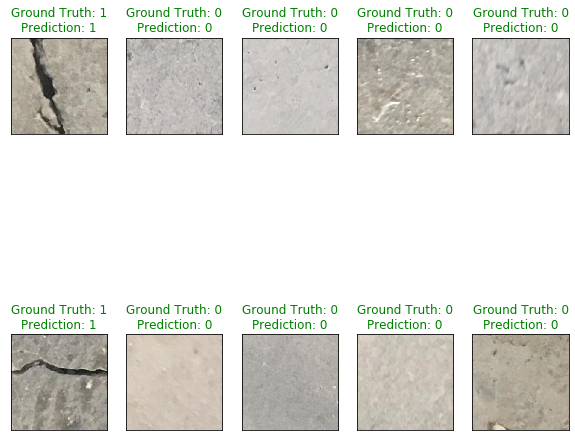

In [10]:
# carregar apenas pesos
# model.load_weights("weights_without_checkpoint.hdf5")

# carregar modelo
model = tf.keras.models.load_model("CNN.model", compile=False)

# imprimir resultados. Passar numero desejado de imagens
get_and_plot_results(10, model)